## 009.Using Simphy to simulate trees


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, subprocess, time, dendropy, os, copy
import numpy as np
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing
import treesignal

In [33]:
def read_tree(path):
    tree = dendropy.Tree.get(path = path, schema="newick", preserve_underscores=True)
    for leaf in tree.leaf_nodes(): # simphy default is to name as numbers
        leaf.taxon.label = "s" + leaf.taxon.label # 1_2_1 becomes s1_2_1
    return tree

def prune_tree(t1):
    max_miss = len(t1.leaf_nodes()) - 4
    if max_miss < 2: # trees always have 5 taxa or more
        return t1
    n_miss = np.random.randint(0,np.ceil(max_miss/2) + 1) # randint excludes upper --> U(0,n-1) inclusive
    tx_miss = [x.label for x in np.random.permutation(t1.taxon_namespace)[:n_miss]]
    return t1.extract_tree_without_taxa_labels(labels=tx_miss)

def simphy(ntaxa=8, n_sp=4, nloci=2):
    ## limited to less than 1000 species trees and loci per sptree (just b/c of padding)
    tmp_dir = "/tmp/simphy"
    cli = "/home/leo/Academic/Biomath/Simulation/SimPhy/bin/simphy"
    # sb, ld, lb, lt are rate of transfers, births, etc. sp. su, st are pop size, tree height, subst rate
    cli += " -sb f:0.0000001 -ld f:0.0000005 -lb f:0.0000005 -lt f:0.0000005 -sp f:10000 -su e:10000 -st f:1000000"
    # sg is generation time, ls is minimum # of species per locus tree, si is indiv/species
    cli += " -sg f:1 -sl F:" + str(ntaxa) + " -ls 4 -o " + tmp_dir
    cli += " -si u:1,2 -rs " + str(n_sp) + " -rl F:" + str(nloci) + " "
    now_time = time.perf_counter()
    proc_run = subprocess.run(cli, shell=True, stdout=subprocess.PIPE, universal_newlines=True)
    now_time = time.perf_counter() - now_time
    print("simphy finished in " + str(now_time) + "secs")
    
    ## read g_treesXX.trees and s_tree.treesfiles from directories 1 ... n_sptrees
    ## (where XX is left-padded number of loci)
    
    if nloci < 10:    n_pad=1
    elif nloci < 100: n_pad=2
    else:             n_pad=3
    if n_sp < 10:    s_pad=1
    elif n_sp < 100: s_pad=2
    else:            s_pad=3
    sp_trees = list(range(n_sp)) # we know sizes beforehand, just fill with arbitrary numbers
    gn_trees = list(range(n_sp))
    for i in range(n_sp):
        spath = tmp_dir + "/" + str(i+1).zfill(s_pad) # this path will be used below
        sp_trees[i] = read_tree(spath + "/s_tree.trees") # dendropy read plus name change
        gn_trees[i] = list(range(nloci))
        for j in range(nloci): 
            t1 = read_tree(spath + "/g_trees" + str(j+1).zfill(n_pad) + ".trees")
            gn_trees[i][j] = prune_tree(t1)
    proc_run = subprocess.run("rm -rf " + tmp_dir, shell=True, stdout=subprocess.PIPE, universal_newlines=True)
    return sp_trees, gn_trees   

In [25]:
n_species = 4

st, gt = simphy(ntaxa=20, nloci=50, n_sp=n_species)
spstring = ""
for sptree in st:
    spstring += sptree.as_string("newick",suppress_edge_lengths=True).rstrip()
print ("spstring:: ", spstring) # dendropy.TreeList(st) also returns treelist object

simphy finished in 0.08588175100157969secs
spstring::  (((((s6,s5),(s2,s1)),(s4,s8)),((s9,s3),(s7,s10))),(((s17,(s20,s14)),(s11,s18)),(((s12,s13),s15),(s19,s16))));((((s7,(s9,s6)),((s1,s5),s4)),((s10,s3),(s8,s2))),((((s15,((s16,s19),s11)),(s18,(s20,s17))),s12),(s13,s14)));(((s6,s1),((((((s2,s4),s5),s8),s3),s7),s9)),((s13,s16),(s18,(s19,(((((s15,s10),s17),s12),(s20,s14)),s11)))));(((s10,s6),((((s9,(s4,((s3,s2),s1))),s12),((s11,s5),s7)),s8)),((((s20,s14),(s17,s15)),s16),(s19,(s18,s13))));


In [26]:
sp2 = treesignal.lowlevel_randomise_trees_with_spr_string(spstring, n_copies=4, n_spr=1)
sp2 = treesignal.lowlevel_randomise_trees_with_spr_string(sp2, n_copies=5, n_spr=3)

In [27]:
sp_treelist = dendropy.TreeList.get( data=sp2, schema="newick")
#for i,t in enumerate(sp_treelist):
#    print (i, " -> ", t.as_string("newick"))
ts = treesignal.TreeSignal(sp_trees = sp_treelist[n_species:], replicates=200) ## remove true sptrees 

In [28]:
def get_tree_sizes(tree):
    sp_names = [leaf.taxon.label.split("_")[0] for leaf in tree.leaf_nodes()]
    return set(sp_names), len(sp_names)

feat_mat = []
label = []
spnames = []
tsize = []
idx = 0
for row in gt:
    for tre in row:
        spectrum = ts(tre)
        if spectrum.max() > -1.:
            feat_mat.append(spectrum)
            label.append(idx)
            nm, sz = get_tree_sizes(tre)
            spnames.append(nm)
            tsize.append(sz)
    idx+=1
feat_mat = np.array(feat_mat)
print ("dimensions: ", feat_mat.shape, len(label)); # print (feat_mat)

dimensions:  (199, 1392) 199


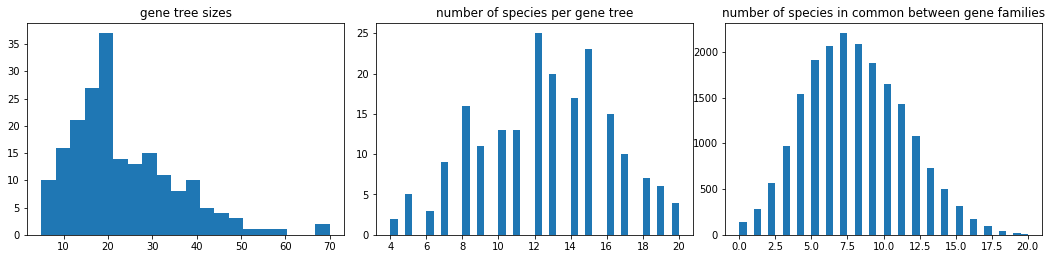

In [29]:
fig, axes = plt.subplots(1,3) ; fig.set_size_inches(15, 3)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)

axes[0].hist(tsize, 20)
axes[0].set_title("gene tree sizes")
axes[1].hist([len(x) for x in spnames], 40)
axes[1].set_title("number of species per gene tree")

common = [len(spnames[i].intersection(spnames[j])) for i in range(len(spnames)) for j in range(i)]
axes[2].hist(common, 40)
axes[2].set_title("number of species in common between gene families")


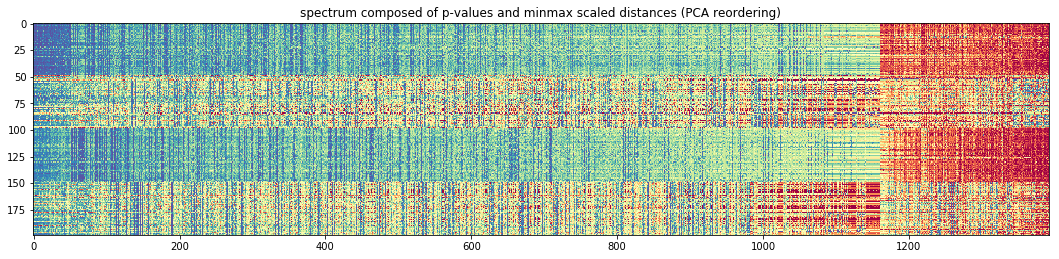

In [37]:
## order of the FEATURES (distances) using first PC 
feat_order = np.argsort(decomposition.PCA(n_components=2).fit_transform(feat_mat.T)[:,0])
fig, axes = plt.subplots(1) ; fig.set_size_inches(15,3)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
axes.imshow(feat_mat[:,feat_order],aspect='auto', cmap="Spectral_r", interpolation="nearest")
axes.set_title("spectrum composed of p-values and minmax scaled distances (PCA reordering)")

In [35]:
#print (feat_mat.max(1)); # print (ts.sp_string)
#fmatrix = feat_mat[:,int(feat_mat.shape[1]/2):]
fmatrix = feat_mat/feat_mat.mean(0)
transf_T = manifold.TSNE(n_components=2, perplexity=20, n_iter=5000).fit_transform(fmatrix)
transf_I = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(fmatrix)
transf_M = manifold.MDS(n_components=2).fit_transform(fmatrix)
transf_S = manifold.SpectralEmbedding(n_components=2).fit_transform(fmatrix)

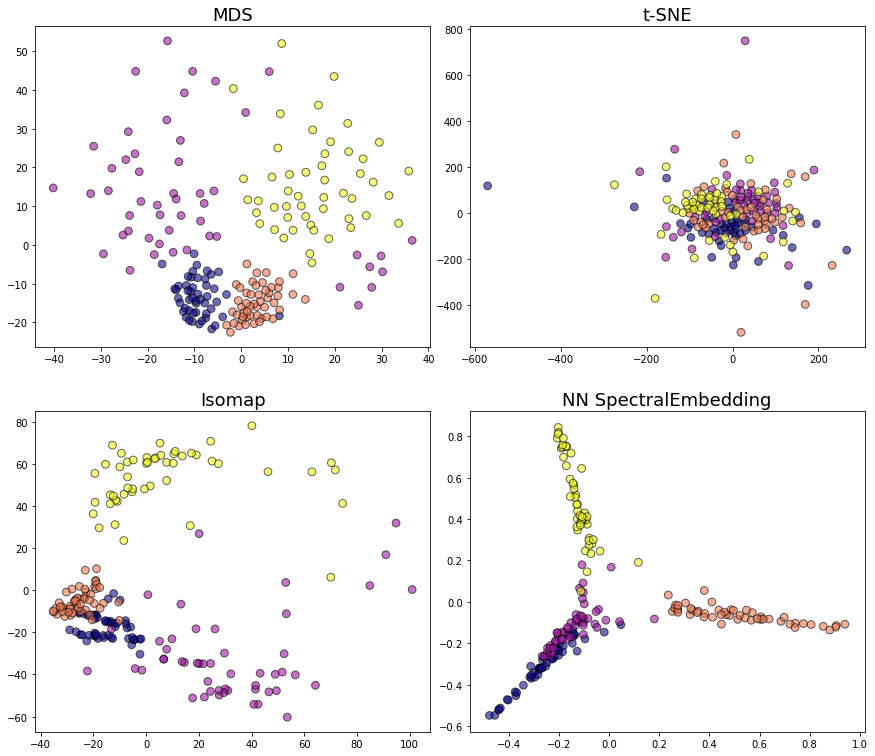

In [36]:
#  %%script false # tell jupyter NOT TO RUN cell (on linux only)
fig, axes = plt.subplots(2,2) ; fig.set_size_inches(12, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.02, right=.98, wspace=.1, hspace=.2)
 
axes[0,0].scatter(transf_M[:,1], transf_M[:,0], c=label, edgecolor="black", cmap="plasma", alpha=.6, s=60)
axes[0,0].set_title("MDS",  fontsize=18)
axes[0,1].scatter(transf_T[:,1], transf_T[:,0], c=label, edgecolor="black", cmap="plasma", alpha=.6, s=60)
axes[0,1].set_title("t-SNE",  fontsize=18)
axes[1,0].scatter(transf_I[:,1], transf_I[:,0], c=label, edgecolor="black", cmap="plasma", alpha=.6, s=60)
axes[1,0].set_title("Isomap",  fontsize=18)
axes[1,1].scatter(transf_S[:,1], transf_S[:,0], c=label, edgecolor="black", cmap="plasma", alpha=.6, s=60)
axes[1,1].set_title("NN SpectralEmbedding",  fontsize=18)